### 对空间流量限制策略的效果进行分析

In [69]:
import os
import numpy as np
import pandas as pd
policy = 'ori_restriction'
#policy = 'detection'
agent_dir = 'outputs//5 states//' + policy + '//gpt-3.5//'
state_list = ['arizona', 'mississippi', 'new mexico', 'texas', 'virginia']
sub_folders = os.listdir(agent_dir)
result_dir = os.path.join(agent_dir, sub_folders[0])


In [70]:
state_name = state_list[0]
log_dir = os.path.join(result_dir, state_name+'.log')
log_file = open(log_dir, 'r')
lines = log_file.readlines()
# lines

In [71]:
import re
def extract_policy_states_from_textfile(txt_path, keep_duplicates=True):
    # 1) 抓取 policy={...} 这一段（尽量不贪婪）
    policy_block_pat = re.compile(r"Parsed PolicyResponse:\s*policy\s*=\s*(\{.*?\})")

    # 2) 在 { ... } 中提取 'state name': 这种 key（支持空格）
    state_key_pat = re.compile(r"'([^']+)'\s*:")

    out = []
    seen = set()

    with open(txt_path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            m = policy_block_pat.search(line)
            if not m:
                continue

            policy_str = m.group(1)  # "{'new mexico': [0.5, 0.5], ...}"
            states = state_key_pat.findall(policy_str)

            for s in states:
                if keep_duplicates:
                    out.append(s)
                else:
                    if s not in seen:
                        seen.add(s)
                        out.append(s)

    return out

# 示例
# states = extract_policy_states_from_textfile("your_log.txt", keep_duplicates=True)
# print(states)


In [72]:
all_policy = {state: [] for state in state_list}
for state in state_list:
    log_dir = os.path.join(result_dir, state+'.log')
    control_states = extract_policy_states_from_textfile(log_dir, keep_duplicates=True)
    # print(control_states)
    # print(len(control_states))
    all_policy[state] = control_states
# all_policy

In [73]:
df_shares = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in all_policy.items()]))
# 统计各个 index (每一行) 下各个 state 出现的频次
freq_df = df_shares.apply(lambda row: row.value_counts(), axis=1).fillna(0).astype(int)
freq_df = freq_df / freq_df.sum(axis=1).values[:, None]
# freq_df
for state in state_list:
    if state not in freq_df.columns:
        freq_df[state] = 0.0
freq_df

,arizona,mississippi,new mexico,texas,virginia
0,0.2,0.0,0.0,0.6,0.2
1,0.4,0.0,0.0,0.4,0.2
2,0.0,0.2,0.4,0.4,0.0
3,0.2,0.0,0.2,0.6,0.0
4,0.0,0.0,0.2,0.8,0.0
5,0.2,0.0,0.2,0.6,0.0
6,0.2,0.0,0.4,0.4,0.0
7,0.0,0.0,0.2,0.8,0.0
8,0.2,0.0,0.0,0.8,0.0
9,0.4,0.0,0.0,0.6,0.0


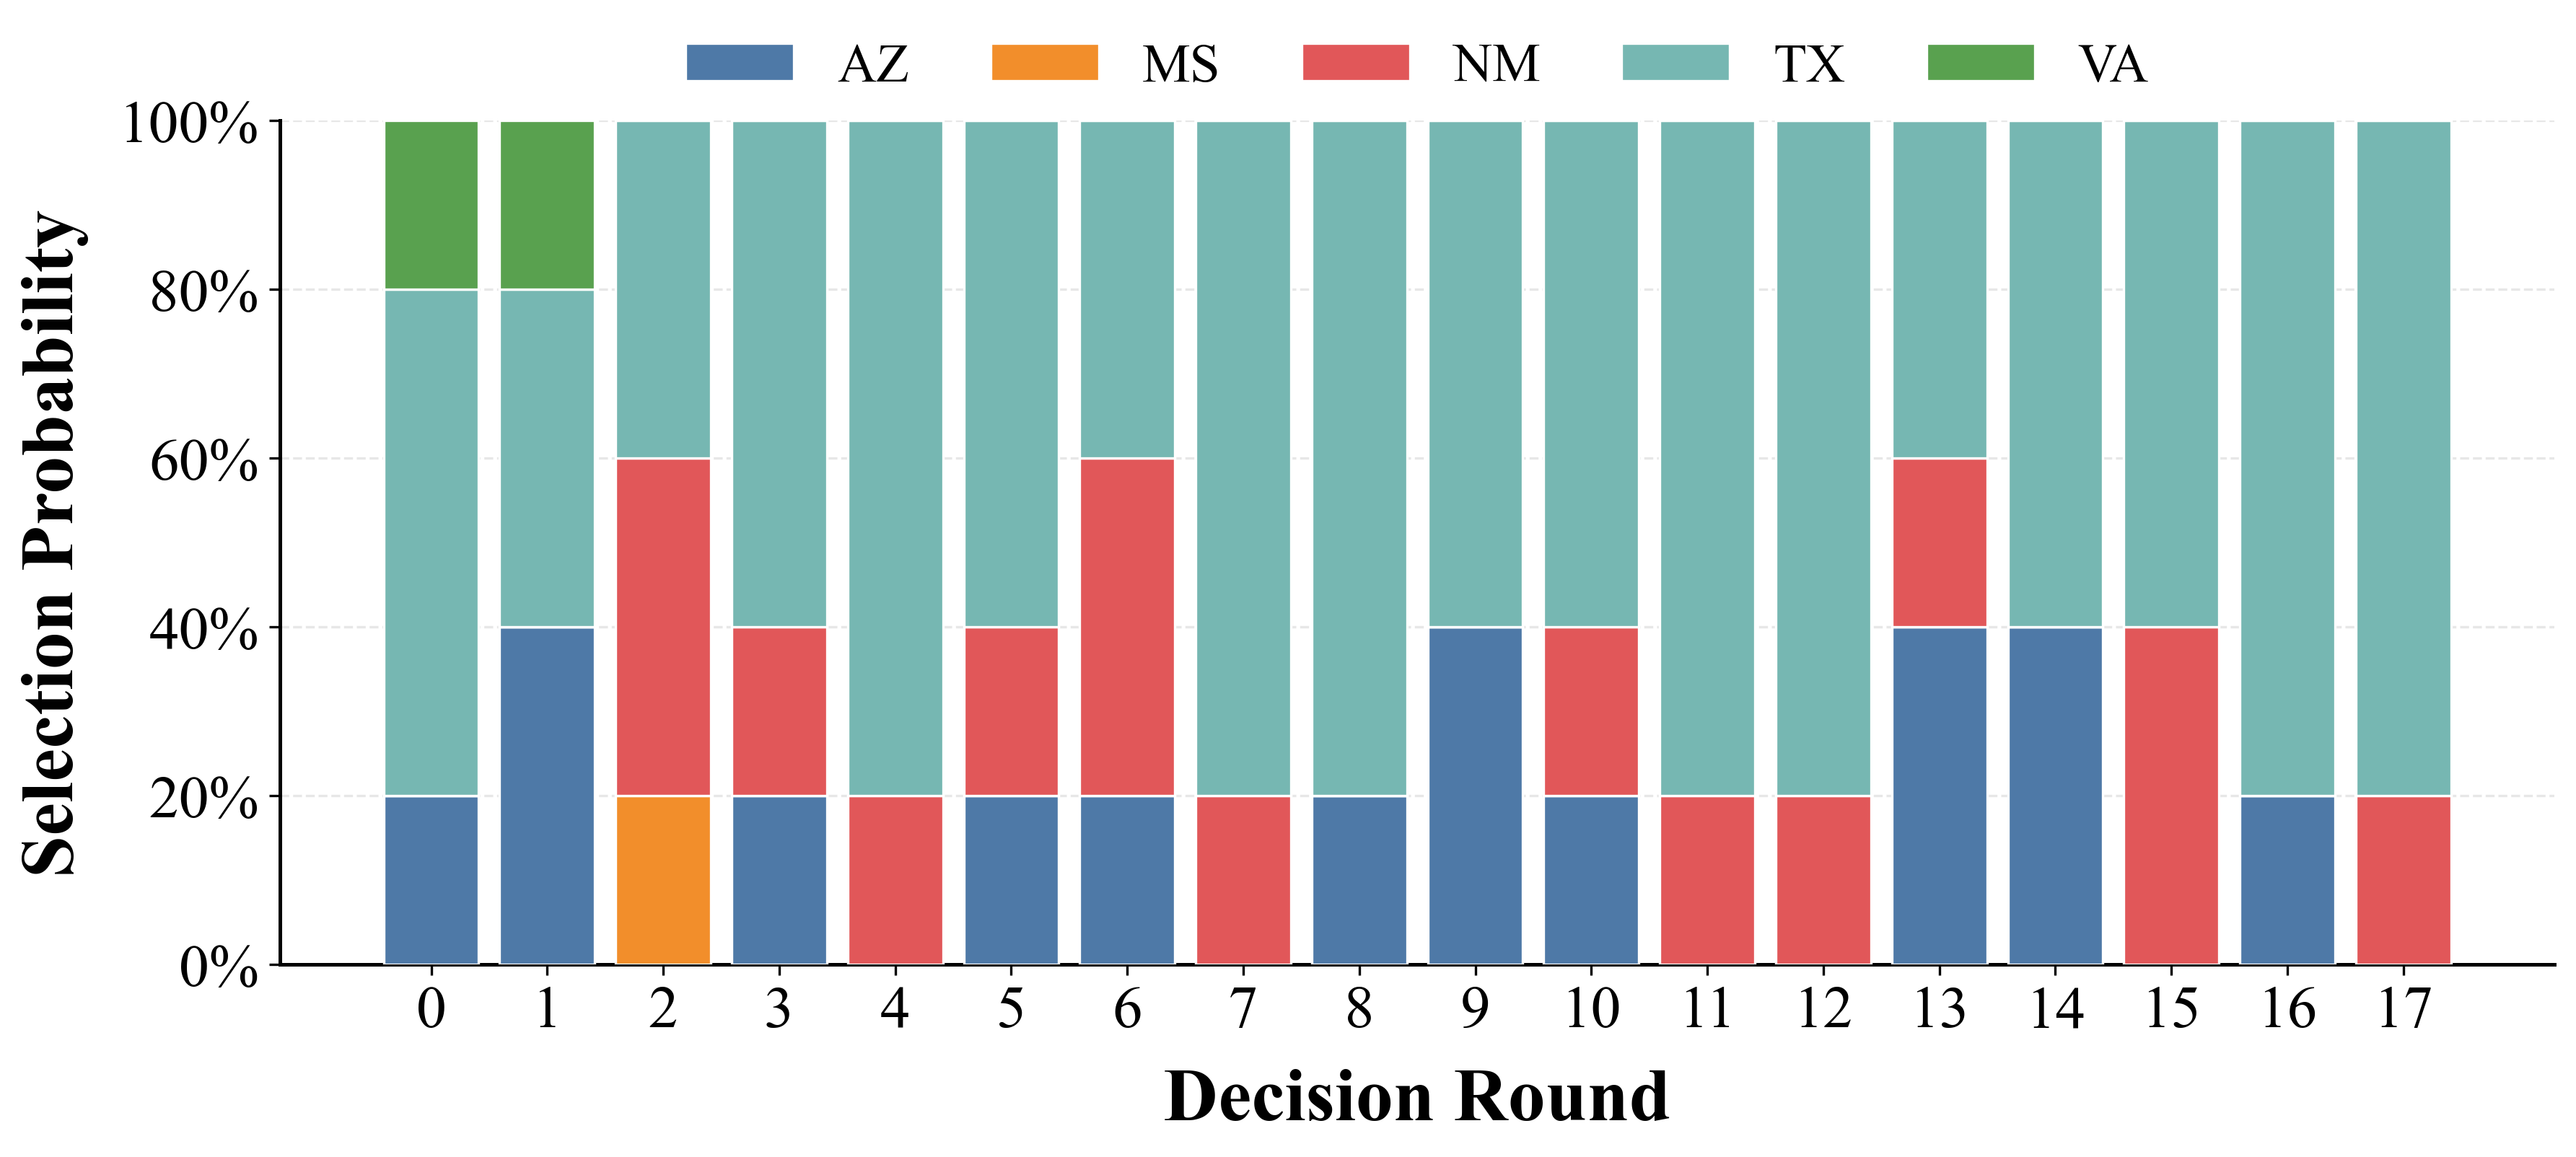

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# df_shares = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in all_policy.items()]))
# # 统计各个 index (每一行) 下各个 state 出现的频次
# freq_df = df_shares.apply(lambda row: row.value_counts(), axis=1).fillna(0).astype(int)
# 设置全局字体 (Times New Roman 为 Nature 常用)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# ===== 数据处理部分保持你的逻辑，但封装为 DataFrame 以便更优雅地处理 =====
abbr = {
    "arizona": "AZ", "mississippi": "MS", "new mexico": "NM", 
    "texas": "TX", "virginia": "VA"
}
# 1. 自动配色：使用更优雅的学术色卡
# 推荐使用：Nature-style color palette (Muted & Distinct)
palette = ["#4E79A7", "#F28E2B", "#E15759", "#76B7B2", "#59A14F"]
fig, ax = plt.subplots(figsize=(12, 5.5), dpi=300)
weeks = freq_df.index.to_numpy()
bottom = np.zeros(len(weeks), dtype=float)
# 2. 绘制堆叠图
for i, s in enumerate(state_list):
    vals = freq_df[s].to_numpy(dtype=float)
    #print(f"State: {s}, Values: {vals}")
    ax.bar(
        weeks, vals, 
        bottom=bottom, 
        width=0.82,          # 留出一点空隙增加呼吸感
        color=palette[i % len(palette)],
        edgecolor="white",   # 改用白边代替黑边，更精致
        linewidth=0.8,
        label=abbr.get(s, s.capitalize()),
        zorder=3
    )
    bottom += vals

# 3. 坐标轴与细节微调 (Nature 风格)
ax.set_xlabel("Decision Round", fontsize=25,  labelpad=10)
ax.set_ylabel("Selection Probability", fontsize=25, labelpad=10)

# 设置 y 轴为百分比
ax.set_ylim(0, 1.0)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'], fontsize=20)

# 设置 x 轴
ax.set_xticks(weeks)
ax.set_xticklabels(weeks, fontsize=20)

# 移除冗余边框 (Despine)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)

# 网格线处理：只保留 Y 轴水平线，且设为极淡
ax.grid(axis="y", linestyle="--", alpha=0.3, zorder=0)

# 4. 图例美化 (横向排列在顶部，节省空间且美观)
ax.legend(
    loc="upper center", 
    bbox_to_anchor=(0.5, 1.15), 
    ncol=len(state_list), 
    frameon=False, 
    fontsize=18,
    columnspacing=1.5
)
output_dir = 'figures//5 states//policy type compare//'
plt.tight_layout()
# 自动保存
plt.savefig(output_dir+ policy + '_policy_selection_share.jpg', bbox_inches='tight', dpi=300)
plt.show()